In [1]:
import torch

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(0)

# Define the Pareto front.
nadir = 0.0 * torch.ones(1, 2, **tkwargs)

pf = torch.tensor(
    [
        [0.45, 0.9],
        [0.9, 0.45],
    ],
    **tkwargs
)

# Polar parametrization.
num_weights = 101
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Partial line.
u = torch.linspace(0, 1, 15).unsqueeze(-1).to(**tkwargs)
partial_weights = unit_vector(u)
s = LengthScalarization(weights=partial_weights, ref_points=nadir)

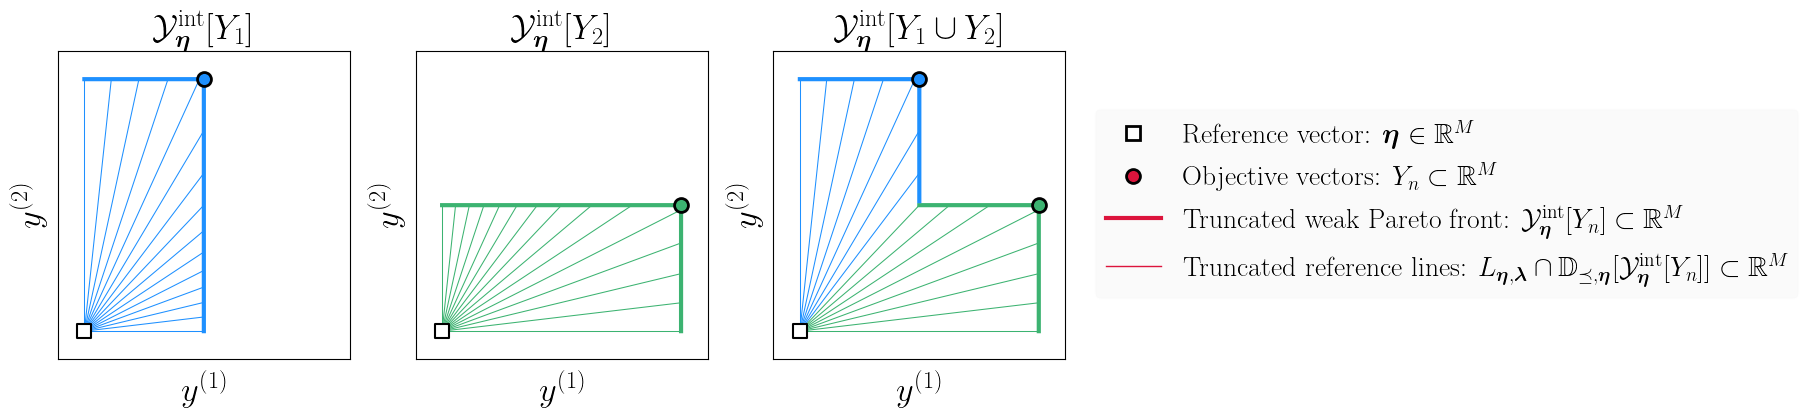

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.225, hspace=0.2
)

colors = ["dodgerblue", "mediumseagreen"]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r"$y^{(1)}$", fontsize=25)
    plt.ylabel(r"$y^{(2)}$", fontsize=25)

########################################################################################
# Draw the individual Pareto fronts.
all_lengths = []
all_partial_lengths = []
for i in range(2):
    plt.subplot(1, 3, i + 1)
    plt.scatter(
        pf[i, 0], pf[i, 1], color=colors[i], edgecolor="k", s=100, zorder=3, linewidth=2
    )
    lengths = s_fn(pf[i, :]).max(dim=0).values
    all_lengths.append(lengths)
    points = nadir + lengths.unsqueeze(-1) * weights
    plt.plot(points[:, 0], points[:, 1], color=colors[i], linewidth=3, zorder=2)

    lengths = s(pf[i, :]).max(dim=0).values
    all_partial_lengths.append(lengths)
    for j, w in enumerate(partial_weights):
        line = nadir + lengths[j] * u * w
        plt.plot(
            line[:, 0], line[:, 1], color=colors[i], alpha=1, linewidth=0.75, zorder=1
        )

    plt.title(
        rf"$\mathcal{{Y}}_{{\boldsymbol{{\eta}}}}^{{\text{{int}}}}[Y_{i+1}]$",
        fontsize=25,
    )

########################################################################################
# Draw the projected lines.
plt.subplot(1, 3, 3)
for i in range(2):
    plt.scatter(
        pf[i, 0], pf[i, 1], color=colors[i], edgecolor="k", s=100, zorder=3, linewidth=2
    )

for j, w in enumerate(partial_weights):
    length_1 = all_partial_lengths[0][j]
    length_2 = all_partial_lengths[1][j]
    color = colors[0] if length_1 > length_2 else colors[1]

    line = nadir + max(length_1, length_2) * u * w
    plt.plot(line[:, 0], line[:, 1], color=color, alpha=1, linewidth=0.75, zorder=1)

########################################################################################
# Draw the colour separated Pareto front.
all_colors = []
index = None
found_index = False
for j, w in enumerate(weights):
    length_1 = all_lengths[0][j]
    length_2 = all_lengths[1][j]
    color = colors[0] if length_1 > length_2 else colors[1]
    all_colors.append(color)
    if index is None:
        index = j
        indexed_color = color
    else:
        if not found_index and indexed_color != color:
            index = j
            other_color = color
            found_index = True

lengths = s_fn(pf).max(dim=0).values
points = nadir + lengths.unsqueeze(-1) * weights
plt.plot(
    points[:index, 0], points[:index, 1], color=indexed_color, linewidth=3, zorder=2
)
plt.plot(points[index:, 0], points[index:, 1], color=other_color, linewidth=3, zorder=2)
plt.title(
    rf"$\mathcal{{Y}}_{{\boldsymbol{{\eta}}}}^{{\text{{int}}}}[Y_1 \cup Y_2]$",
    fontsize=25,
)

########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

pink_circle = mlines.Line2D(
    [],
    [],
    color="crimson",
    marker=".",
    linestyle="None",
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    alpha=1,
    label=r"Objective vectors: $Y_n \subset \mathbb{R}^M$",
)

pink_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Truncated weak Pareto front: $\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[Y_n] \subset \mathbb{R}^M$",
)

pink_line_thin = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=1,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Truncated reference lines: $L_{\boldsymbol{\eta}, \boldsymbol{\lambda}} \cap \mathbb{D}_{\preceq, \boldsymbol{\eta}}[\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[Y_n]] \subset \mathbb{R}^M$",
)

axes[2].legend(
    handles=[white_square, pink_circle, pink_line, pink_line_thin],
    ncol=1,
    fontsize=20,
    loc=(1.1, 0.2),
    facecolor="k",
    framealpha=0.02,
)
plt.show()